In [1]:
# Title: Food Data Analysis
# Author: Shery Cheong
# Description: Imputate missing sugar levels, rank fruit sweetness
# Date: 03/31/21
# Version: 1.0

######################################################################################################################################################
##### Housekeeping #####
######################################################################################################################################################

# Import all needed packages
import csv
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Don't truncate display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ("Imported libraries - success")

Imported libraries - success


In [2]:
######################################################################################################################################################
##### Data Input #####
######################################################################################################################################################

# Read in excel input (header is 2nd row)
df = pd.read_excel('2017-2018 FNDDS At A Glance - FNDDS Nutrient Values.xlsx', header=1,sheet_name='FNDDS Nutrient Values',engine='openpyxl')
print ('Dataframe head')
display (df.head())
print('\n')

Dataframe head


,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),"Fatty acids, total saturated (g)","Fatty acids, total monounsaturated (g)","Fatty acids, total polyunsaturated (g)",Cholesterol (mg),Retinol (mcg),"Vitamin A, RAE (mcg_RAE)","Carotene, alpha (mcg)","Carotene, beta (mcg)","Cryptoxanthin, beta (mcg)",Lycopene (mcg),Lutein + zeaxanthin (mcg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Vitamin B-6 (mg),Folic acid (mcg),"Folate, food (mcg)","Folate, DFE (mcg_DFE)","Folate, total (mcg)","Choline, total (mg)",Vitamin B-12 (mcg),"Vitamin B-12, added\n(mcg)",Vitamin C (mg),Vitamin D (D2 + D3) (mcg),Vitamin E (alpha-tocopherol) (mg),"Vitamin E, added\n(mg)",Vitamin K (phylloquinone) (mcg),Calcium (mg),Phosphorus (mg),Magnesium (mg),Iron\n(mg),Zinc\n(mg),Copper (mg),Selenium (mcg),Potassium (mg),Sodium (mg),Caffeine (mg),Theobromine (mg),Alcohol (g),4:0\n(g),6:0\n(g),8:0\n(g),10:0\n(g),12:0\n(g),14:0\n(g),16:0\n(g),18:0\n(g),16:1\n(g),18:1\n(g),20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
0,11000000,"Milk, human",9602,Human milk,70,1.03,6.89,6.89,0.00,4.38,2.01,1.66,0.50,14,60,61,0,7,0,0,0,0.01,0.04,0.18,0.01,0,5,5,5,16.00,0.05,0.00,5.00,0.10,0.08,0.00,0.30,32,14,3,0.03,0.17,0.05,1.80,51,17,0,0,0.00,0.00,0.00,0.00,0.06,0.26,0.32,0.92,0.29,0.13,1.48,0.04,0.00,0.37,0.05,0.00,0.03,0.00,0.00,0.00,87.50
1,11100000,"Milk, NFS",1004,"Milk, reduced fat",51,3.34,4.87,4.89,0.00,1.99,1.16,0.43,0.07,8,58,59,0,4,0,0,0,0.06,0.14,0.11,0.06,0,1,1,1,17.90,0.56,0.00,0.10,1.10,0.03,0.00,0.20,126,103,12,0.00,0.42,0.00,1.90,157,39,0,0,0.00,0.04,0.03,0.02,0.05,0.06,0.19,0.54,0.19,0.03,0.43,0.00,0.00,0.07,0.01,0.00,0.00,0.00,0.00,0.00,89.04
2,11111000,"Milk, whole",1002,"Milk, whole",60,3.28,4.67,4.81,0.00,3.20,1.86,0.69,0.11,12,31,32,0,7,0,0,0,0.06,0.14,0.10,0.06,0,0,0,0,17.80,0.54,0.00,0.00,1.10,0.05,0.00,0.30,123,101,12,0.00,0.41,0.00,1.90,150,38,0,0,0.00,0.07,0.05,0.03,0.08,0.10,0.30,0.86,0.31,0.05,0.69,0.00,0.00,0.12,0.01,0.00,0.00,0.00,0.00,0.00,88.10
3,11111100,"Milk, low sodium, whole",1002,"Milk, whole",61,3.10,4.46,4.46,0.00,3.46,2.15,1.00,0.13,14,28,29,0,7,0,0,0,0.02,0.10,0.04,0.03,0,5,5,5,16.00,0.36,0.00,0.90,1.30,0.08,0.00,0.30,101,86,5,0.05,0.38,0.01,2.00,253,3,0,0,0.00,0.11,0.07,0.04,0.09,0.10,0.35,0.91,0.42,0.08,0.87,0.00,0.00,0.08,0.05,0.00,0.00,0.00,0.00,0.00,88.20
4,11111150,"Milk, calcium fortified, whole",1002,"Milk, whole",60,3.28,4.67,4.81,0.00,3.20,1.86,0.69,0.11,12,31,32,0,7,0,0,0,0.06,0.14,0.10,0.06,0,0,0,0,17.80,0.54,0.00,0.00,1.10,0.05,0.00,0.30,123,101,12,0.00,0.41,0.00,1.90,150,38,0,0,0.00,0.07,0.05,0.03,0.08,0.10,0.30,0.86,0.31,0.05,0.69,0.00,0.00,0.12,0.01,0.00,0.00,0.00,0.00,0.00,88.10


In [3]:
######################################################################################################################################################
##### EDA Part 1 #####
######################################################################################################################################################

# Check column types
print ('Dataframe column types')
df.info()
print('\n')

# Check data size
print ('Dataframe size')
print(df.shape)
print('\n')

# Check uniqueness of each column
print ('Column Uniqueness')
print(df.nunique(axis=0))
print('\n')

# Check for null/missing values
print ('Dataframe missing values across all columns')
print (df.isnull().sum().sum())
print('\n')

Dataframe column types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7083 entries, 0 to 7082
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Food code                               7083 non-null   int64  
 1   Main food description                   7083 non-null   object 
 2   WWEIA Category number                   7083 non-null   int64  
 3   WWEIA Category description              7083 non-null   object 
 4   Energy (kcal)                           7083 non-null   int64  
 5   Protein (g)                             7083 non-null   float64
 6   Carbohydrate (g)                        7083 non-null   float64
 7   Sugars, total
(g)                       7083 non-null   float64
 8   Fiber, total dietary (g)                7083 non-null   float64
 9   Total Fat (g)                           7083 non-null   float64
 10  Fatty acids, total saturated (g)     

In [4]:
######################################################################################################################################################
##### Feature Selection #####
######################################################################################################################################################

# There are too many features to do more in-depth EDA, so we would like to trim down the number

# Define x and y variables
y = df['Sugars, total\n(g)']
X = df.drop(['Sugars, total\n(g)'],axis=1)

# There are too many unique categorical variables to convert them all to dummy variables, so we should eliminate them from X
# We will also eliminate Food code, which is just the unique identifier for each food
X = X.drop(['Main food description','WWEIA Category description','Food code'], 1)

# Select top features that have strongest relationship with Y variable using SelectKBest. Let's say k=15 (this is arbitrary but can probably be tuned)
# We plan to use this in a regression model, so let's set score function to be f_regression
best_features = SelectKBest(score_func=f_regression,k=15)
fit = best_features.fit(X,y)

# Extract out the scores and columns
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenate both dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
print(feature_scores.nlargest(15,'Score'))  # print best features

# Define new X set
X_reduced = X[(feature_scores.nlargest(15,'Score'))['Feature_Name']]

# Check distribution of data for each independent var in X reduced
print ('Column Data Distribution')
print(X_reduced.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))))
print('\n')

                  Feature_Name   Score
3             Carbohydrate (g) 6309.73
64                  Water\n(g) 2502.15
1                Energy (kcal) 1300.07
0        WWEIA Category number  635.79
43            Theobromine (mg)  620.45
2                  Protein (g)  385.92
60                   20:4\n(g)  243.33
21            Folic acid (mcg)  221.31
27  Vitamin B-12, added\n(mcg)  218.58
49                   12:0\n(g)  204.28
25         Choline, total (mg)  192.15
52                   18:0\n(g)  184.16
23       Folate, DFE (mcg_DFE)  170.49
36                  Iron\n(mg)  164.98
9             Cholesterol (mg)  159.97
Column Data Distribution
      Carbohydrate (g)   Water\n(g) Energy (kcal) WWEIA Category number  \
count      7083.000000  7083.000000   7083.000000           7083.000000   
mean         20.828039    59.798820    197.121559           4698.965975   
std          21.887363    26.828203    140.705036           2212.828607   
min           0.000000     0.000000      0.000000  

VIF


,variables,VIF
0,Carbohydrate (g),6.74
1,Water\n(g),6.07
2,Energy (kcal),15.14
3,WWEIA Category number,8.17
4,Theobromine (mg),1.18
5,Protein (g),5.05
6,20:4\n(g),3.35
7,Folic acid (mcg),20.33
8,"Vitamin B-12, added\n(mcg)",2.22
9,12:0\n(g),1.10


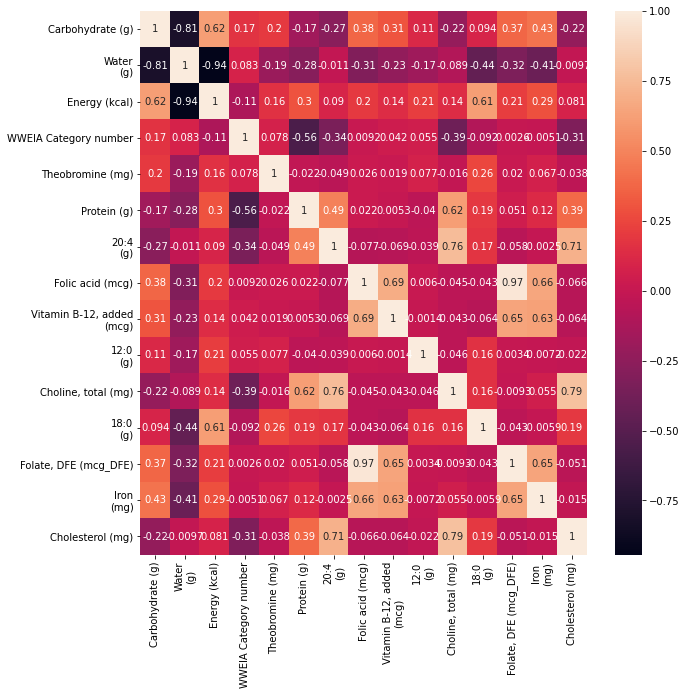

In [5]:
######################################################################################################################################################
##### EDA Part 2 #####
######################################################################################################################################################

# Calculate correlation matrix
corr = X_reduced.corr()
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(corr, annot=True,ax=ax)

# Calculating variance inflation factor to check multicollinearity
vif = pd.DataFrame()
vif["variables"] = X_reduced.columns
vif["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
print ("VIF")

display (vif)

##### Analysis #####
Both suggest there are extremely high correlations between Water and Carb, Water and Energy, Folic Acid and Folate, DFE. In that case, we will drop Water and Folate from the feature set.

In [6]:
######################################################################################################################################################
##### Remove highly correlated variables #####
######################################################################################################################################################

X_reduced = X_reduced.drop(['Folate, DFE (mcg_DFE)','Water\n(g)'], 1)

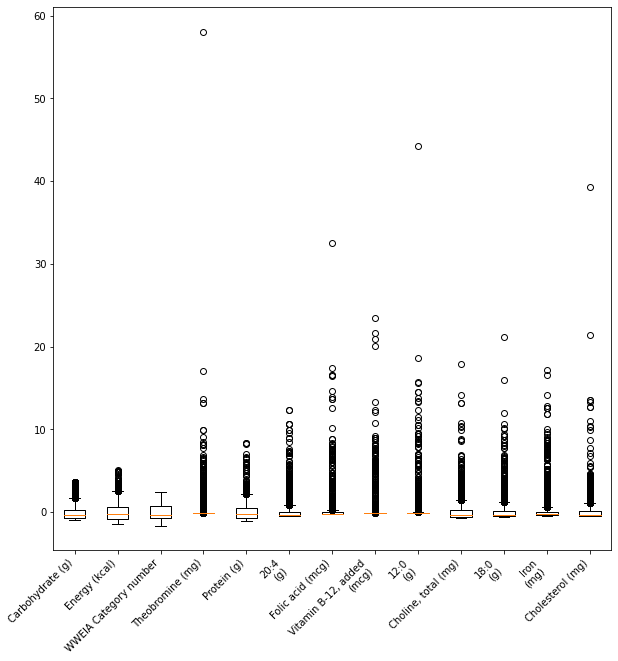

In [7]:
######################################################################################################################################################
##### EDA Part 3 #####
######################################################################################################################################################
# Standardize independent variables
# This is so we can plot all the columns on the same boxplot and also not have variable weights skewed by magnitude in our model later on

def standardize(df):
    scaler = StandardScaler()
    df2 = pd.DataFrame(scaler.fit_transform(df))
    df2.columns = df.columns.values
    df2.index = df.index.values
    return df2

# Standardize all
X_reduced_std = standardize(X_reduced)

# Create a box plot for each column in standardized reduced X set to detect outlier possibilities
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(X_reduced_std)
ax.set_xticklabels(list(X_reduced.columns),rotation = 45, ha="right")
plt.show()

##### Analysis #####

It looks like there are extreme outlier records in some columns, such as Theobromine, Folic acid, 12:0, and Cholesterol. Let's remove records where they are 3 or more standard deviations from the mean (more extreme than 99.7% of observed dataset)


In [8]:
######################################################################################################################################################
##### Remove outlier records #####
######################################################################################################################################################

# Combine new X and Y
df_new = pd.concat([X_reduced_std, y],axis=1)

z = np.abs(stats.zscore(X_reduced_std))

print (z)

df_new = df_new[(z < 3).all(axis=1)]

print (df_new.shape)

[[ 0.63685256  0.90352511  2.21588792 ...  0.3618501   0.47357091
   0.26407493]
 [ 0.72914978  1.0385689   1.669911   ...  0.45444167  0.48182278
   0.34152064]
 [ 0.73828812  0.97460079  1.67081489 ...  0.34688581  0.48182278
   0.28989017]
 ...
 [ 0.4216447   1.03146133  2.39530897 ...  0.63027213  0.31678538
   0.44478157]
 [ 0.16851274  0.52509604  2.39530897 ...  0.24046275  0.36354597
   0.27698255]
 [ 0.95166831  4.93889572  2.39530897 ... 21.12126509  0.47082029
   0.44478157]]
(6396, 14)


In [9]:
# Split final data set to dependent vs independent variables    
y_final = df_new['Sugars, total\n(g)']
X_final = df_new.drop(['Sugars, total\n(g)'], axis = 1)

######################################################################################################################################################
##### First pass: Simple 80/20 split of Data Set #####
######################################################################################################################################################

# Split data into train vs test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, shuffle=True, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

display(X_train.head())
display(X_test.head())

Number transactions X_train dataset:  (5116, 13)
Number transactions y_train dataset:  (5116,)
Number transactions X_test dataset:  (1280, 13)
Number transactions y_test dataset:  (1280,)


,Carbohydrate (g),Energy (kcal),WWEIA Category number,Theobromine (mg),Protein (g),20:4\n(g),Folic acid (mcg),"Vitamin B-12, added\n(mcg)",12:0\n(g),"Choline, total (mg)",18:0\n(g),Iron\n(mg),Cholesterol (mg)
4158,-0.31,-0.83,0.05,-0.13,-0.86,-0.49,0.26,-0.15,-0.11,-0.70,-0.45,0.62,-0.41
3250,1.51,0.47,-0.22,-0.13,0.07,-0.49,0.29,-0.15,-0.16,-0.52,-0.64,-0.26,-0.44
2655,-0.69,-0.97,-0.41,-0.13,-0.70,-0.49,-0.23,-0.15,-0.06,-0.54,-0.29,-0.42,-0.32
2366,-0.05,0.13,-0.45,-0.13,1.59,0.48,0.00,-0.15,-0.15,0.39,-0.41,-0.04,0.30
6092,-0.36,-0.94,0.78,-0.13,-0.69,-0.49,-0.23,-0.15,-0.16,-0.24,-0.63,-0.26,-0.44


,Carbohydrate (g),Energy (kcal),WWEIA Category number,Theobromine (mg),Protein (g),20:4\n(g),Folic acid (mcg),"Vitamin B-12, added\n(mcg)",12:0\n(g),"Choline, total (mg)",18:0\n(g),Iron\n(mg),Cholesterol (mg)
2177,-0.67,-0.55,-0.77,-0.13,-0.24,-0.08,-0.22,-0.15,-0.05,-0.39,-0.10,-0.26,-0.16
3297,1.26,0.51,-0.22,-0.13,-0.02,-0.49,0.15,-0.15,-0.15,-0.36,-0.50,0.26,-0.44
3788,1.67,1.53,0.23,-0.13,0.12,-0.49,0.45,-0.15,-0.08,-0.45,-0.06,0.47,-0.24
5584,-0.64,-1.00,0.77,-0.13,-0.69,-0.49,-0.23,-0.15,-0.13,0.22,-0.48,-0.18,-0.42
6465,2.19,0.57,1.86,-0.13,-0.99,-0.49,-0.23,-0.15,-0.16,-0.55,-0.64,-0.35,-0.44


In [10]:
######################################################################################################################################################
##### Linear Regression #####
######################################################################################################################################################

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

reg = LinearRegression().fit(X_train, y_train)

# Test model on the test set
y_test_pred = reg.predict(X_test)

######################################################################################################################################################
##### Linear Regression - Evaluation #####
######################################################################################################################################################

# evaluate via RMSE
#note that for the mean_squared_error() function, the parameter "squared=False" will return the RMSE value
rms = mean_squared_error(y_test, y_test_pred, squared=False)
print('RMSE - test:', rms)

# evaluate via R-squared
r_sq = r2_score(y_test, y_test_pred)
print('R Squared Score - test:', r_sq)
print ('')

# Print actual vs predicted values for Sugar
print (pd.DataFrame(list(zip(y_test,y_test_pred)),columns=['y_test_actual','y_test_pred']).head())


RMSE - test: 7.323089640965444
R Squared Score - test: 0.5427716808287659

   y_test_actual  y_test_pred
0           1.38         0.88
1           8.14        11.02
2           0.00        11.28
3           0.55         3.66
4          48.50        30.55


##### Analysis #####
The R squared is rather low when ran on the test set, so perhaps a linear regression model isn't the best fit.
Let's try a polynomial regression next, which might capture some non-linear patterns in the underlying data

In [11]:
######################################################################################################################################################
##### Polynomial Regression #####
######################################################################################################################################################

from sklearn.preprocessing import PolynomialFeatures

# Fitting Polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree=3)
X_train_poly = poly_reg.fit_transform(X_train)
pol_reg = LinearRegression()
pol_reg.fit(X_train_poly, y_train)


# Trying polynomial regression model on the test set

# Transform test data to convert into polynomial form
X_test_poly = poly_reg.fit_transform(X_test)

# Predicting on test set
y_test_pred_poly = pol_reg.predict(poly_reg.fit_transform(X_test))

######################################################################################################################################################
##### Polynomial Regression - Evaluation #####
######################################################################################################################################################

# evaluate via RMSE
rms2 = mean_squared_error(y_test, y_test_pred_poly, squared=False)
print('RMSE - test:', rms2)

r_sq2 = r2_score(y_test, y_test_pred_poly)
print('R Squared Score - test:', r_sq2)
print ('')

# Print actual vs predicted values for Sugar
print (pd.DataFrame(list(zip(y_test,y_test_pred_poly)),columns=['y_test_actual','y_test_pred']).head())

RMSE - test: 21.80945879508237
R Squared Score - test: -3.055404679207326

   y_test_actual  y_test_pred
0           1.38         0.66
1           8.14         9.72
2           0.00        11.06
3           0.55         0.13
4          48.50        54.99


##### Analysis #####

Based on the RMSE, it looks like Polynomial Regression with degree of 3 actually does worse for testing data set for linear regression!
Also the R-squared value is abnormal. We will try a non parametric method next.

In [12]:
######################################################################################################################################################
##### Decision Tree Regression #####
######################################################################################################################################################

from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

# create a regressor object
rt = DecisionTreeRegressor()
  
# fit the regressor with training data
tree_reg = rt.fit(X_train, y_train)

# show feature importance
print ('Feature Importance, Ranked')
i = 0
for importance, name in sorted(zip(rt.feature_importances_, X_train.columns),reverse=True):
    i += 1
    print (i, name, importance)
print ('')


# run on test set
y_test_pred_tree = tree_reg.predict(X_test)

######################################################################################################################################################
##### Decision Tree Regression - Evaluation #####
######################################################################################################################################################

# evaluate via RMSE
rms3 = mean_squared_error(y_test, y_test_pred_tree, squared=False)
print('RMSE - test:', rms3)

# evaluate via R-squared
r_sq3 = r2_score(y_test, y_test_pred_tree)
print('R Squared Score - test:', r_sq3)
print ('')

# Print actual vs predicted values for Sugar
print (pd.DataFrame(list(zip(y_test,y_test_pred_tree)),columns=['y_test_actual','y_test_pred']).head())

Feature Importance, Ranked
1 Carbohydrate (g) 0.44040660978820556
2 WWEIA Category number 0.3326320240147247
3 Protein (g) 0.07612625843026272
4 Choline, total (mg) 0.03189102828326895
5 Folic acid (mcg) 0.02647759937827773
6 Energy (kcal) 0.021399297423125897
7 Iron
(mg) 0.01978117693569064
8 12:0
(g) 0.017448538239001662
9 18:0
(g) 0.012658155676934613
10 20:4
(g) 0.006891345251566347
11 Cholesterol (mg) 0.00656082809886951
12 Theobromine (mg) 0.0040761132901546895
13 Vitamin B-12, added
(mcg) 0.0036510251899170352

RMSE - test: 4.527632659569457
R Squared Score - test: 0.8252219906305045

   y_test_actual  y_test_pred
0           1.38         1.32
1           8.14         8.14
2           0.00         5.47
3           0.55         0.55
4          48.50        42.68


##### Analysis #####

R-Squared is reasonably high for this model, so I am ok with this. 
The feature ranks make sense intuitively as well, such as the carb content ranked as most important in determining sugar level.


##### Extending to Brazilian Market  #####

If I were to apply this model to the Brazilian Market, I would assume that there is a similar breakout in food types (processed vs homemade), access to the same raw ingredients (i.e. fruits, vegetables, meat cuts), and flavor profiles (similar preference in level of sweetness and saltiness). It was also mentioned in the assignment memo that often times we do not have sugar content data available for the Brazilian market, so we would also want to know what features are available and what overlap is there with the US feature set. 

To prove or disprove these assumptions, I would compare the distribution of available features like carbohydrate content, energy (kcal), between the US and Brazilian data sets to see if they are relatively similar. I would compare the mean, median, standard deviation and the percentiles of these features for both sets.

In [13]:
######################################################################################################################################################
##### Rank Fruit Sweetness #####
######################################################################################################################################################

# Rank the basic fruit groups (cherries, bananas, apple, oranges etc) by their sweetness meaning total sugar / 100g
# Since we imported the dataset earlier, we can re-use the dataframe for part 2 of the assignment

# Define basic fruit groups
fruit_groups = ['Apple','Bananas','Grapes','Peaches and nectarines','Strawberries','Blueberries and other berries',
                'Citrus fruits', 'Melons', 'Dried fruits', 'Other fruits and fruit salads', 'Pears',
                'Pineapple', 'Mango and papaya']

# Assuming that this excludes dried and canned fruits and we only want "raw" fruits

# Filter original data set for basic fruits category and "raw" fruits
df_fruits = df[(df['WWEIA Category description'].isin(fruit_groups)) & (df['Main food description'].str.contains(", raw"))]

# Sort by sugar content, decreasing
df_fruits_sorted = df_fruits.sort_values('Sugars, total\n(g)', ascending=False).reset_index()

# Output relevant columns
print ('Basic Fruits (Raw) - Ranked from most to least sweet')
df_fruits_sorted[['Main food description','WWEIA Category description','Sugars, total\n(g)']]

Basic Fruits (Raw) - Ranked from most to least sweet


,Main food description,WWEIA Category description,"Sugars, total\n(g)"
0,"Fig, raw",Other fruits and fruit salads,16.26
1,"Grapes, raw",Grapes,15.48
2,"Pomegranate, raw",Other fruits and fruit salads,13.67
3,"Mango, raw",Mango and papaya,13.66
4,"Cherries, raw",Other fruits and fruit salads,12.82
5,"Persimmon, raw",Other fruits and fruit salads,12.53
6,"Banana, raw",Bananas,12.23
7,"Passion fruit, raw",Other fruits and fruit salads,11.20
8,"Clementine, raw",Citrus fruits,10.58
9,"Tangerine, raw",Citrus fruits,10.58
